In [1]:
# importing of modules for CIFAR-10 CNN 
from tensorflow.keras.datasets import cifar100
import tensorflow.keras.applications as apps
from tensorflow.keras import utils
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.optimizers.legacy import SGD, Adam, RMSprop
from tensorflow.keras.losses import categorical_crossentropy
import tensorflow as tf
# importing of service libraries
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
# Learning rate (0.0001, 0.1, 0.5), dropout rate (0, 0.4, 0.8), architecture (alexNet, vggNet, resnet), optimisers (sgd, adam, rmsprop), data aug
learningRates = [0.005, 0.015, 0.075]
dropoutRates = [0.1, 0.5, 0.75]
print('Libraries imported.')
tf._logging.disable()
# mpl.rcParams['figure.dpi'] = 100


2024-04-22 23:49:26.079207: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-22 23:49:26.098933: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-22 23:49:26.098958: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-22 23:49:26.099626: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-22 23:49:26.103624: I tensorflow/core/platform/cpu_feature_guar

Libraries imported.


The following constant and variable definitions are needed for the network and training parameters.


In [2]:
#training constants
BATCH_SIZE = 100
N_EPOCH = 100 # use 20 for best initial results
N_CLASSES = 100
VERBOSE = 1
VALIDATION_SPLIT = 0.2

print('Main variables initialised.')

Main variables initialised.


Constant definition for the training set images

In [3]:
# CIFAR_10 is a set of 60K images 32x32 pixels on 3 channels
IMG_CHANNELS = 3
IMG_ROWS = 32
IMG_COLS = 32

print('Image variables initialisation')

Image variables initialisation


__CIFAR-10 data loading and processing__

Loading and preparation of the CIFAR-10 training set.

In [4]:
#load dataset
(input_X_train, output_y_train), (input_X_test, output_y_test) = cifar100.load_data()
print('input_X_train shape:', input_X_train.shape)
print(input_X_train.shape[0], 'train samples')
print(input_X_test.shape[0], 'test samples')
 
# convert to categorical
output_Y_train = utils.to_categorical(output_y_train, N_CLASSES)
output_Y_test = utils.to_categorical(output_y_test, N_CLASSES) 
# idx = np.random.permutation(len(input_X_train))
# input_X_train, output_Y_train = input_X_train[idx], output_Y_train[idx]
# # float and normalization
input_X_train = input_X_train.astype('float32')
input_X_test = input_X_test.astype('float32')
input_X_train /= 255
input_X_test /= 255


input_X_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


**Visualisation of two sample CIFAR-10 images**

Here we will visualise two sample images from the dataset.

In [5]:
vgg = apps.VGG16(classes=N_CLASSES, weights=None, include_top=False, pooling="max", input_shape=input_X_train[0].shape)
flatten = Flatten()(vgg.layers[-2].output)
dense1 = Dense(2048, activation="relu")(flatten)
dense2 = Dense(2048, activation="relu")(dense1)
predictions = Dense(N_CLASSES, activation="softmax", name="predictions")(dense2)
model = tf.keras.Model(inputs=vgg.inputs, outputs=predictions)
model.summary()
model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.SGD(), metrics=['accuracy'])

2024-04-22 23:49:27.732872: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-22 23:49:27.744450: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-22 23:49:27.744482: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-22 23:49:27.746181: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-22 23:49:27.746207: I external/local_xla/xla/stream_executor

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0     

**Training of the CNN**

This line of code trains the model, saving the results in the history variable.



In [6]:
es = tf.keras.callbacks.EarlyStopping(verbose=1, patience=35, start_from_epoch=10, restore_best_weights=True)

In [7]:
# training/fitting of the DNN model
# train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input)
# history = model.fit(train_datagen.flow(input_X_train[0:round(len(input_X_train)*(1 - VALIDATION_SPLIT))], 
#                                        output_Y_train[0:round(len(output_Y_train)*(1 - VALIDATION_SPLIT))], 
#                                        batch_size=Bn  ATCH_SIZE), 
#                                        validation_data=train_datagen.flow(
#                                            input_X_train[round(len(input_X_train)*(1 - VALIDATION_SPLIT)):len(input_X_train)],
#                                            output_Y_train[round(len(output_Y_train)*(1 - VALIDATION_SPLIT)):len(output_Y_train)], 
#                                            batch_size=BATCH_SIZE

#                                        ), epochs=N_EPOCH,  verbose=VERBOSE, callbacks=[es])
history = model.fit(np.array(input_X_train), np.array(output_Y_train), batch_size=BATCH_SIZE, epochs=N_EPOCH, validation_split=VALIDATION_SPLIT,  verbose=VERBOSE, callbacks=[es])
model.save("vgg_def.keras")
np.save("vgg_def_history.npy", history.history)

Epoch 1/100


2024-04-22 21:12:49.902785: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
2024-04-22 21:12:50.040455: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-04-22 21:12:50.568868: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-04-22 21:12:50.640082: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f72896a2780 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-22 21:12:50.640110: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 SUPER, Compute Capability 8.9
I0000 00:00:1713816770.686094  198020 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


400/400 [==============================] - 11s 17ms/step - loss: 4.6052 - accuracy: 0.0100 - val_loss: 4.6053 - val_accuracy: 0.0085
Epoch 2/100
400/400 [==============================] - 7s 16ms/step - loss: 4.6052 - accuracy: 0.0106 - val_loss: 4.6054 - val_accuracy: 0.0077
Epoch 3/100
400/400 [==============================] - 6s 16ms/step - loss: 4.6051 - accuracy: 0.0104 - val_loss: 4.6055 - val_accuracy: 0.0077
Epoch 4/100
400/400 [==============================] - 6s 16ms/step - loss: 4.6051 - accuracy: 0.0103 - val_loss: 4.6056 - val_accuracy: 0.0077
Epoch 5/100
400/400 [==============================] - 6s 16ms/step - loss: 4.6050 - accuracy: 0.0105 - val_loss: 4.6058 - val_accuracy: 0.0077
Epoch 6/100
400/400 [==============================] - 6s 16ms/step - loss: 4.6050 - accuracy: 0.0106 - val_loss: 4.6059 - val_accuracy: 0.0077
Epoch 7/100
400/400 [==============================] - 6s 16ms/step - loss: 4.6050 - accuracy: 0.0108 - val_loss: 4.6060 - val_accuracy: 0.0077
Epo

**Analysis of the results**

This code generates the test scores, so we can visualise and inspect the model's peformance.

It also plots the accuracy and loss values along the training timescale.


100/100 [==============================] - 1s 6ms/step - loss: 8.0253 - accuracy: 0.2203

Test score/loss: 8.02531623840332
Test accuracy: 0.22030000388622284
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


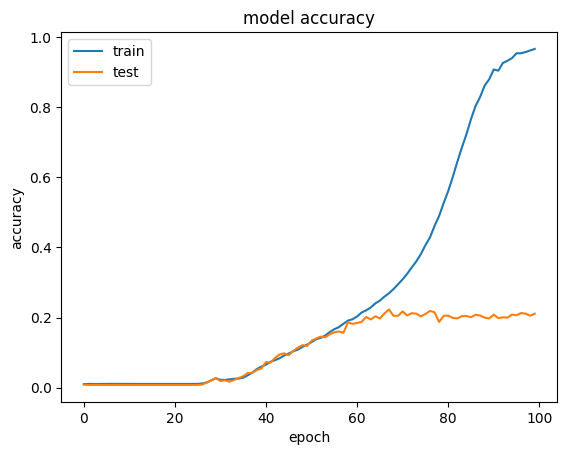

67


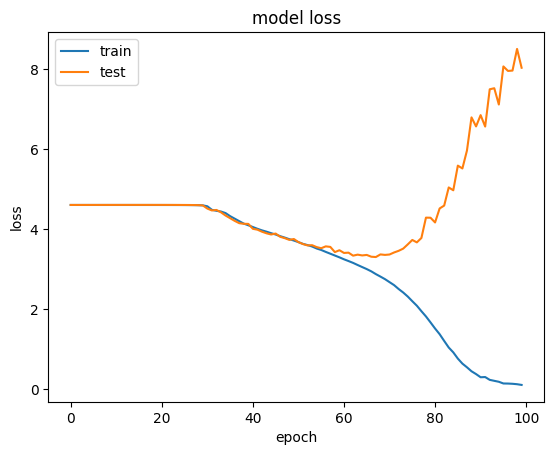

In [9]:
#
model = tf.keras.saving.load_model("vgg_def.keras")
history = np.load("vgg_def_history.npy", allow_pickle='TRUE').item()
score = model.evaluate(input_X_test, output_Y_test, batch_size=BATCH_SIZE, verbose=VERBOSE)
print("\nTest score/loss:", score[0])
print('Test accuracy:', score[1])

# list all data in history
print(history.keys())

# summarize history for accuracy
#plt.plot(mo)
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
print(np.argmin(history["val_loss"]))
# summarize history for loss
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


In [14]:
# es = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", mode="max", verbose=1, patience=20, start_from_epoch=50, restore_best_weights=True)
# from keras.preprocessing.image import ImageDataGenerator
# datagen = ImageDataGenerator(
#    width_shift_range=0.2,
#    height_shift_range=0.2,
#    zoom_range=0.2,
#    horizontal_flip=True,
#    brightness_range=[0.2,1.2],
#    fill_mode='nearest')

# #fit the dataset
# datagen.fit(input_X_train)
# vgg = apps.VGG16(classes=N_CLASSES, weights=None, include_top=False, pooling="max", input_shape=input_X_train[0].shape)
# flatten = Flatten()(vgg.layers[-2].output)
# dense1 = Dense(2048, activation="relu")(flatten)
# dropout1 = tf.keras.layers.Dropout(0.5)(dense1)
# dense2 = Dense(2048, activation="relu")(dropout1)
# dropout2 = tf.keras.layers.Dropout(0.5)(dense2)
# predictions = Dense(N_CLASSES, activation="softmax", name="predictions")(dropout2)
# model = tf.keras.Model(inputs=vgg.inputs, outputs=predictions)
# model.summary()
# model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.SGD(learning_rate=0.015, momentum=0.9), metrics=['accuracy'])
# history = model.fit(datagen.flow(input_X_train, output_Y_train, batch_size=BATCH_SIZE), steps_per_epoch=input_X_train.shape[0]//BATCH_SIZE, epochs=N_EPOCH * 2, verbose=1)
# model.save(f"vgg_augmented.keras")
# np.save(f"vgg_augmented_history.npy", history.history)

# # train by fitting the model on batches with real-time data augmentation


In [8]:
inp = tf.keras.Input(shape=(IMG_ROWS, IMG_COLS, IMG_CHANNELS))
conv1 = tf.keras.layers.Conv2D(kernel_size=11, filters=82, padding="same", strides=(2, 2), activation="relu")(inp)
pool1 = tf.keras.layers.MaxPool2D(pool_size=(3, 3), strides=(1, 1))(conv1)
conv2 = tf.keras.layers.Conv2D(kernel_size=5 , padding="same", filters=168, activation="relu", strides=(1, 1))(pool1)
pool2 = tf.keras.layers.MaxPool2D(pool_size=(3, 3), strides=(1, 1))(conv2)
conv3 = tf.keras.layers.Conv2D(kernel_size=3, filters=212, activation="relu", padding="same", strides=(1, 1))(pool2)
conv4 = tf.keras.layers.Conv2D(kernel_size=3, filters=212, activation="relu", padding="same", strides=(1, 1))(conv3)
conv5 = tf.keras.layers.Conv2D(kernel_size=3, filters=212, activation="relu", padding="same", strides=(1, 1))(conv4)
pool3 = tf.keras.layers.MaxPool2D(pool_size=(3, 3), strides=(1, 1))(conv5)
flatten = tf.keras.layers.Flatten()(pool3)
dense1 = tf.keras.layers.Dense(units=2048, activation="relu")(flatten)
dense2 = tf.keras.layers.Dense(units=2048, activation="relu")(dense1)
predictions = tf.keras.layers.Dense(units=N_CLASSES, activation="softmax")(dense2)
model = tf.keras.Model(inputs=inp, outputs=predictions)
model.summary()
model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.SGD(), metrics=['accuracy'])
history = model.fit(np.array(input_X_train), np.array(output_Y_train), batch_size=BATCH_SIZE, epochs=N_EPOCH, validation_split=VALIDATION_SPLIT, verbose=VERBOSE, callbacks=[es])
model.save(f"alexNet_def.keras")
np.save(f"alexNet_def_history.npy", history.history)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_10 (Conv2D)          (None, 16, 16, 82)        29848     
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 14, 14, 82)        0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 14, 14, 168)       344568    
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 12, 12, 168)       0         
 g2D)                                                            
                                                                 
 conv2d_12 (Conv2D)          (None, 12, 12, 212)       3207

100/100 [==============================] - 1s 5ms/step - loss: 4.9596 - accuracy: 0.3170

Test score/loss: 4.959563732147217
Test accuracy: 0.31700000166893005
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


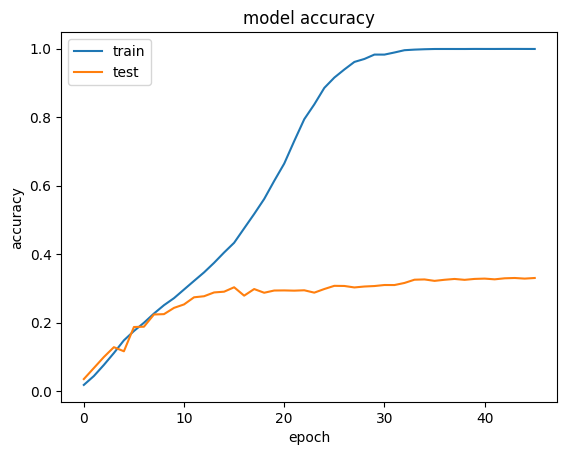

15


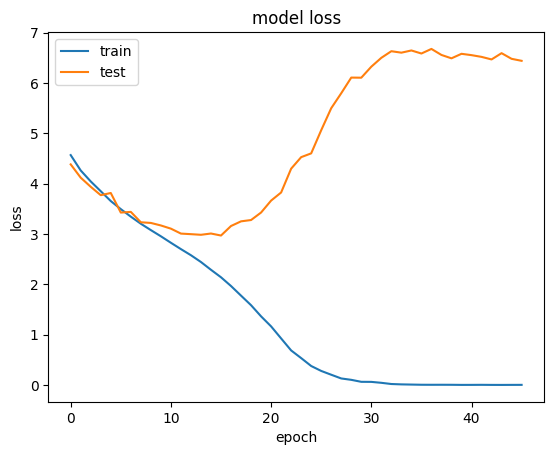

In [12]:
model = tf.keras.saving.load_model("alexNet_def.keras")
history = np.load("alexNet_def_history.npy", allow_pickle='TRUE').item()
score = model.evaluate(input_X_test, output_Y_test, batch_size=BATCH_SIZE, verbose=VERBOSE)
print("\nTest score/loss:", score[0])
print('Test accuracy:', score[1])

# list all data in history
print(history.keys())

# summarize history for accuracy
#plt.plot(mo)
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
print(np.argmin(history["val_loss"]))
# summarize history for loss
plt.plot(history['loss'])
plt.plot(history["val_loss"])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [10]:
for p in dropoutRates:
    inp = tf.keras.Input(shape=(IMG_ROWS, IMG_COLS, IMG_CHANNELS))
    conv1 = tf.keras.layers.Conv2D(kernel_size=11, filters=82, padding="same", strides=(2, 2), activation="relu")(inp)
    pool1 = tf.keras.layers.MaxPool2D(pool_size=(3, 3), strides=(1, 1))(conv1)
    conv2 = tf.keras.layers.Conv2D(kernel_size=5 , padding="same", filters=168, activation="relu", strides=(1, 1))(pool1)
    pool2 = tf.keras.layers.MaxPool2D(pool_size=(3, 3), strides=(1, 1))(conv2)
    conv3 = tf.keras.layers.Conv2D(kernel_size=3, filters=212, activation="relu", padding="same", strides=(1, 1))(pool2)
    conv4 = tf.keras.layers.Conv2D(kernel_size=3, filters=212, activation="relu", padding="same", strides=(1, 1))(conv3)
    conv5 = tf.keras.layers.Conv2D(kernel_size=3, filters=212, activation="relu", padding="same", strides=(1, 1))(conv4)
    pool3 = tf.keras.layers.MaxPool2D(pool_size=(3, 3), strides=(1, 1))(conv5)
    flatten = tf.keras.layers.Flatten()(pool3)
    dense1 = tf.keras.layers.Dense(units=2048, activation="relu")(flatten)
    dropout1 = tf.keras.layers.Dropout(p)(dense1)
    dense2 = tf.keras.layers.Dense(units=2048, activation="relu")(dropout1)
    dropout2 = tf.keras.layers.Dropout(p)(dense2)
    predictions = tf.keras.layers.Dense(units=N_CLASSES, activation="softmax")(dropout2)
    model = tf.keras.Model(inputs=inp, outputs=predictions)
    model.summary()
    model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.SGD(), metrics=['accuracy'])
    
    history = model.fit(np.array(input_X_train), np.array(output_Y_train), batch_size=BATCH_SIZE, epochs=N_EPOCH, validation_split=VALIDATION_SPLIT, verbose=VERBOSE, callbacks=[es])
    model.save(f"alexNet_dropout_{p}.keras")
    np.save(f"alexNet_dropout_{p}_history.npy", history.history)

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_15 (Conv2D)          (None, 16, 16, 82)        29848     
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 14, 14, 82)        0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 14, 14, 168)       344568    
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 12, 12, 168)       0         
 ng2D)                                                           
                                                                 
 conv2d_17 (Conv2D)          (None, 12, 12, 212)       3207

100/100 [==============================] - 1s 5ms/step - loss: 3.3274 - accuracy: 0.3264

Test score/loss: 3.3274171352386475
Test accuracy: 0.3264000117778778


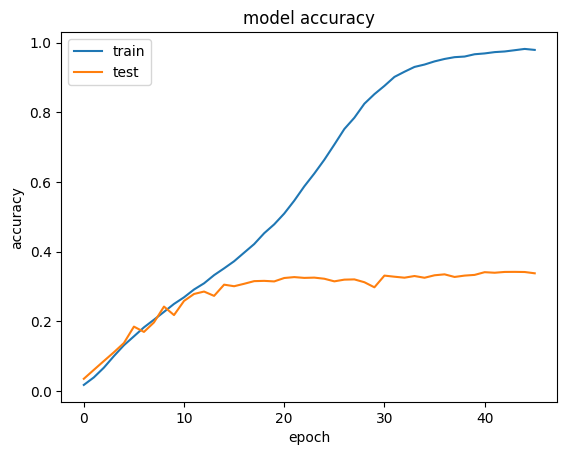

16


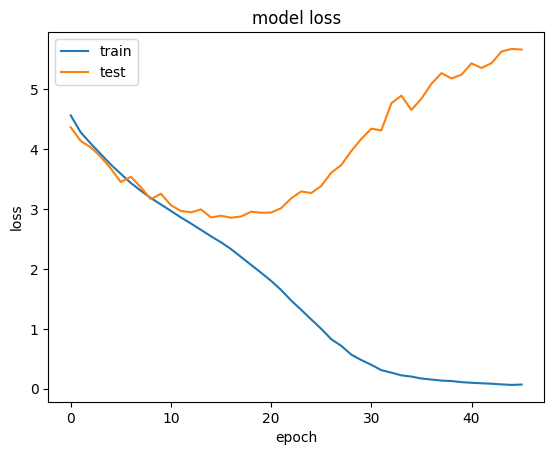

100/100 [==============================] - 1s 5ms/step - loss: 2.3319 - accuracy: 0.4166

Test score/loss: 2.3318536281585693
Test accuracy: 0.41659998893737793


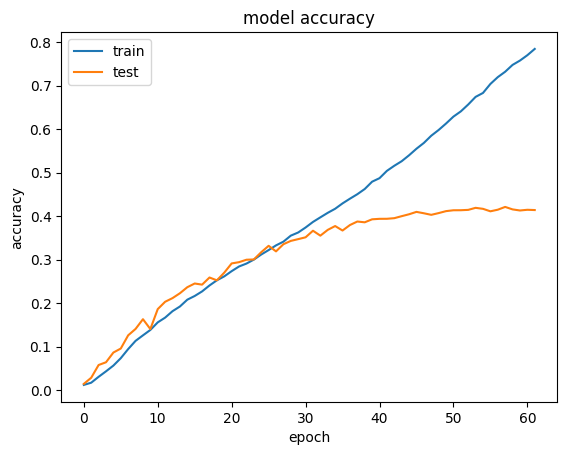

41


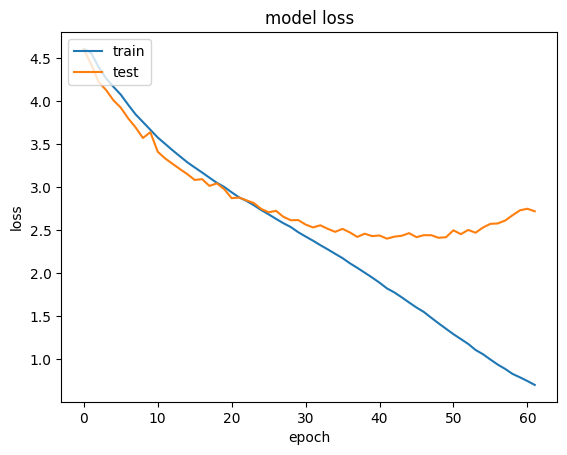

100/100 [==============================] - 1s 5ms/step - loss: 2.3463 - accuracy: 0.4259

Test score/loss: 2.34631609916687
Test accuracy: 0.42590001225471497


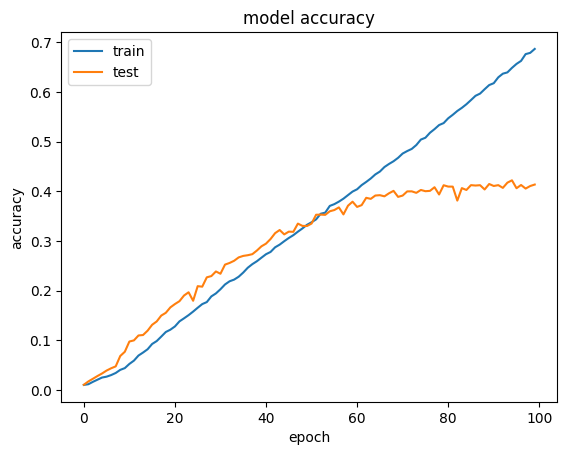

79


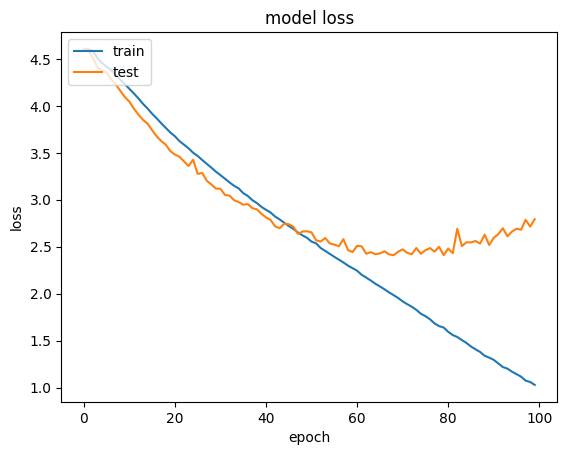

In [13]:
for p in dropoutRates:
    model = tf.keras.saving.load_model(f"alexNet_dropout_{p}.keras")
    history = np.load(f"alexNet_dropout_{p}_history.npy", allow_pickle='TRUE').item()
    score = model.evaluate(input_X_test, output_Y_test, batch_size=BATCH_SIZE, verbose=VERBOSE)
    print("\nTest score/loss:", score[0])
    print('Test accuracy:', score[1])
    # summarize history for accuracy
    #plt.plot(mo)
    plt.plot(history['accuracy'])
    plt.plot(history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    print(np.argmin(history["val_loss"]))
    # summarize history for loss
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [10]:
optimisers = [tf.keras.optimizers.SGD, tf.keras.optimizers.RMSprop, tf.keras.optimizers.Adagrad]
for i in range(2, len(optimisers)):
    inp = tf.keras.Input(shape=(IMG_ROWS, IMG_COLS, IMG_CHANNELS))
    conv1 = tf.keras.layers.Conv2D(kernel_size=11, filters=82, padding="same", strides=(2, 2), activation="relu")(inp)
    pool1 = tf.keras.layers.MaxPool2D(pool_size=(3, 3), strides=(1, 1))(conv1)
    conv2 = tf.keras.layers.Conv2D(kernel_size=5 , padding="same", filters=168, activation="relu", strides=(1, 1))(pool1)
    pool2 = tf.keras.layers.MaxPool2D(pool_size=(3, 3), strides=(1, 1))(conv2)
    conv3 = tf.keras.layers.Conv2D(kernel_size=3, filters=212, activation="relu", padding="same", strides=(1, 1))(pool2)
    conv4 = tf.keras.layers.Conv2D(kernel_size=3, filters=212, activation="relu", padding="same", strides=(1, 1))(conv3)
    conv5 = tf.keras.layers.Conv2D(kernel_size=3, filters=212, activation="relu", padding="same", strides=(1, 1))(conv4)
    pool3 = tf.keras.layers.MaxPool2D(pool_size=(3, 3), strides=(1, 1))(conv5)
    flatten = tf.keras.layers.Flatten()(pool3)
    dense1 = tf.keras.layers.Dense(units=2048, activation="relu")(flatten)
    dropout1 = tf.keras.layers.Dropout(dropoutRates[1])(dense1)
    dense2 = tf.keras.layers.Dense(units=2048, activation="relu")(dropout1)
    dropout2 = tf.keras.layers.Dropout(dropoutRates[1])(dense2)
    predictions = tf.keras.layers.Dense(units=N_CLASSES, activation="softmax")(dropout2)
    model = tf.keras.Model(inputs=inp, outputs=predictions)
    model.summary()
    optimizer = optimisers[i]()
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    history = model.fit(np.array(input_X_train), np.array(output_Y_train), batch_size=BATCH_SIZE, epochs=N_EPOCH, validation_split=VALIDATION_SPLIT, verbose=VERBOSE, callbacks=[es])
    model.save(f"alexNet_optim_{i}_def.keras")
    np.save(f"alexNet_optim_{i}_history.npy", history.history)

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_15 (Conv2D)          (None, 16, 16, 82)        29848     
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 14, 14, 82)        0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 14, 14, 168)       344568    
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 12, 12, 168)       0         
 ng2D)                                                           
                                                                 
 conv2d_17 (Conv2D)          (None, 12, 12, 212)       3207

100/100 [==============================] - 1s 7ms/step - loss: 2.3409 - accuracy: 0.4092

Test score/loss: 2.3408939838409424
Test accuracy: 0.4092000126838684


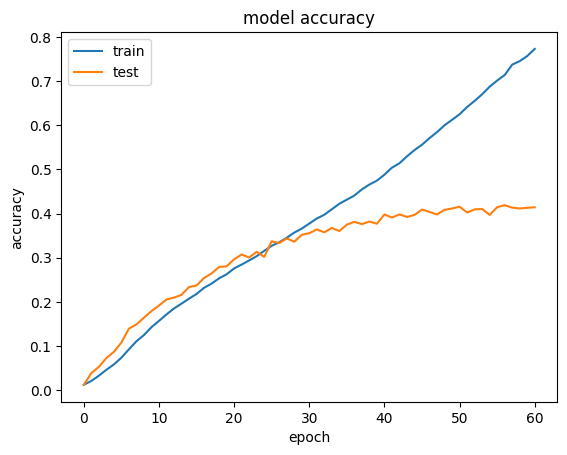

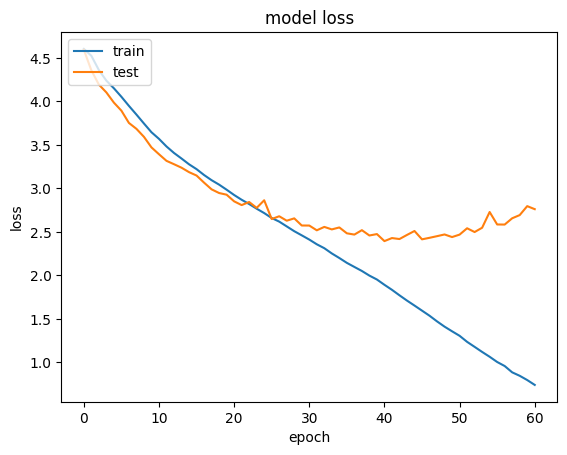

100/100 [==============================] - 1s 6ms/step - loss: 3.0346 - accuracy: 0.2947

Test score/loss: 3.034604549407959
Test accuracy: 0.2946999967098236


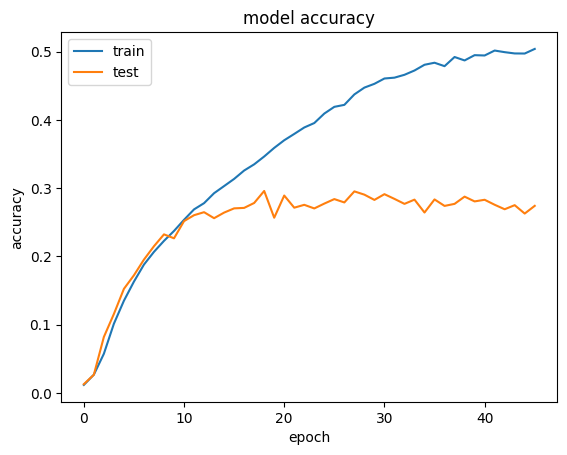

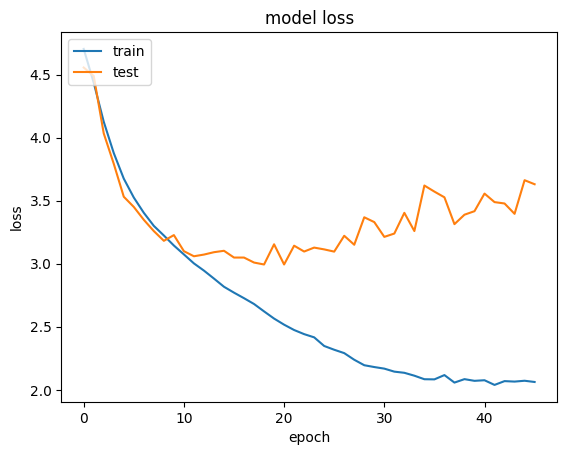

100/100 [==============================] - 1s 6ms/step - loss: 2.5880 - accuracy: 0.3584

Test score/loss: 2.5880348682403564
Test accuracy: 0.35839998722076416


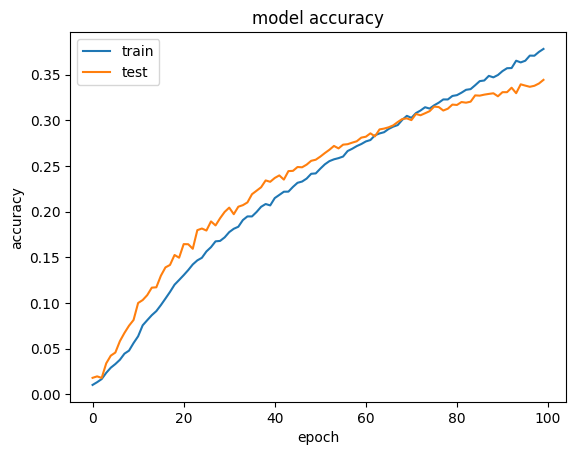

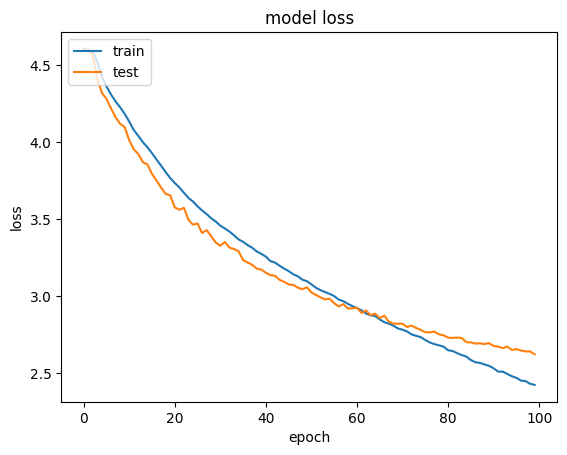

In [11]:
for i in range(0, len(optimisers)):
    model = tf.keras.saving.load_model(f"alexNet_optim_{i}_def.keras")
    history = np.load(f"alexNet_optim_{i}_history.npy", allow_pickle='TRUE').item()
    score = model.evaluate(input_X_test, output_Y_test, batch_size=BATCH_SIZE, verbose=VERBOSE)
    print("\nTest score/loss:", score[0])
    print('Test accuracy:', score[1])
    # summarize history for accuracy
    #plt.plot(mo)
    plt.plot(history['accuracy'])
    plt.plot(history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    # summarize history for loss
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [26]:

for i in range(0, len(learningRates)):
    lr = learningRates[i]
    inp = tf.keras.Input(shape=(IMG_ROWS, IMG_COLS, IMG_CHANNELS))
    conv1 = tf.keras.layers.Conv2D(kernel_size=11, filters=82, padding="same", strides=(2, 2), activation="relu")(inp)
    pool1 = tf.keras.layers.MaxPool2D(pool_size=(3, 3), strides=(1, 1))(conv1)
    conv2 = tf.keras.layers.Conv2D(kernel_size=5 , padding="same", filters=168, activation="relu", strides=(1, 1))(pool1)
    pool2 = tf.keras.layers.MaxPool2D(pool_size=(3, 3), strides=(1, 1))(conv2)
    conv3 = tf.keras.layers.Conv2D(kernel_size=3, filters=212, activation="relu", padding="same", strides=(1, 1))(pool2)
    conv4 = tf.keras.layers.Conv2D(kernel_size=3, filters=212, activation="relu", padding="same", strides=(1, 1))(conv3)
    conv5 = tf.keras.layers.Conv2D(kernel_size=3, filters=212, activation="relu", padding="same", strides=(1, 1))(conv4)
    pool3 = tf.keras.layers.MaxPool2D(pool_size=(3, 3), strides=(1, 1))(conv5)
    flatten = tf.keras.layers.Flatten()(pool3)
    dense1 = tf.keras.layers.Dense(units=2048, activation="relu")(flatten)
    dropout1 = tf.keras.layers.Dropout(dropoutRates[1])(dense1)
    dense2 = tf.keras.layers.Dense(units=2048, activation="relu")(dropout1)
    dropout2 = tf.keras.layers.Dropout(dropoutRates[1])(dense2)
    predictions = tf.keras.layers.Dense(units=N_CLASSES, activation="softmax")(dropout2)
    model = tf.keras.Model(inputs=inp, outputs=predictions)
    model.summary()
    model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.SGD(learning_rate=lr), metrics=['accuracy'])
    history = model.fit(np.array(input_X_train), np.array(output_Y_train), batch_size=BATCH_SIZE, epochs=N_EPOCH, validation_split=VALIDATION_SPLIT, verbose=VERBOSE, callbacks=[es])
    model.save(f"alexNet_lr_{lr}_def.keras")
    np.save(f"alexNet_lr_{lr}_history.npy", history.history)

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_25 (Conv2D)          (None, 16, 16, 82)        29848     
                                                                 
 max_pooling2d_21 (MaxPooli  (None, 14, 14, 82)        0         
 ng2D)                                                           
                                                                 
 conv2d_26 (Conv2D)          (None, 14, 14, 168)       344568    
                                                                 
 max_pooling2d_22 (MaxPooli  (None, 12, 12, 168)       0         
 ng2D)                                                           
                                                                 
 conv2d_27 (Conv2D)          (None, 12, 12, 212)       3207

100/100 [==============================] - 1s 5ms/step - loss: 2.7115 - accuracy: 0.4338

Test score/loss: 2.711547374725342
Test accuracy: 0.43380001187324524


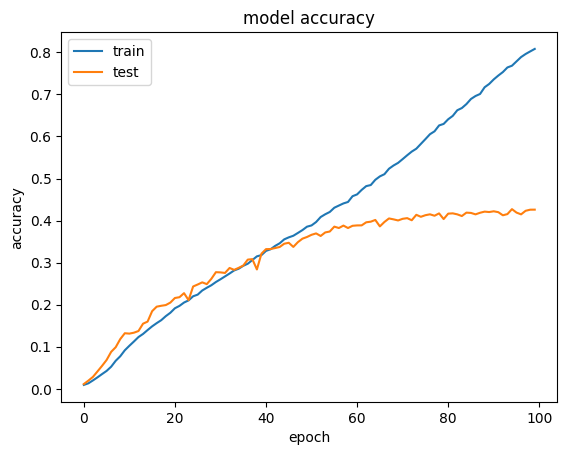

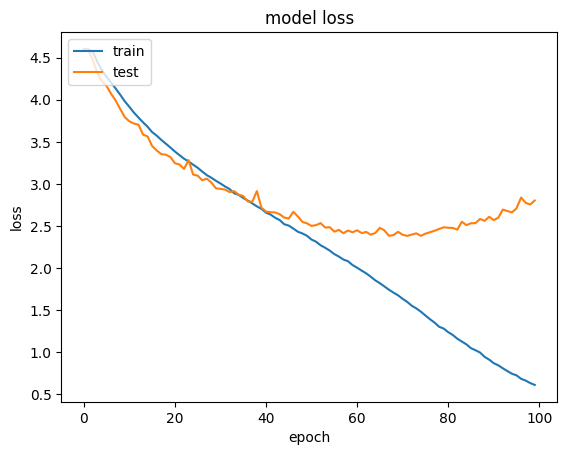

100/100 [==============================] - 1s 5ms/step - loss: 2.3197 - accuracy: 0.4294

Test score/loss: 2.319701671600342
Test accuracy: 0.4293999969959259


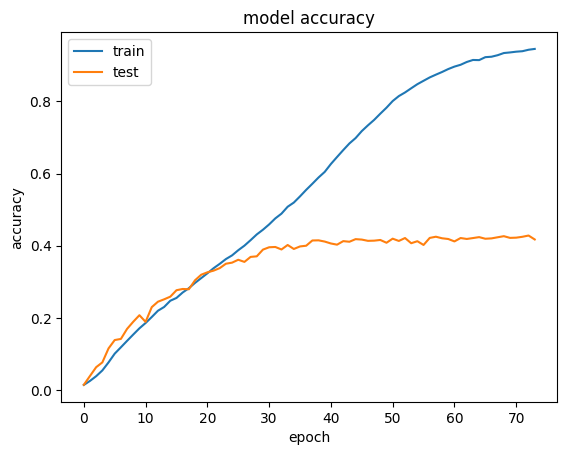

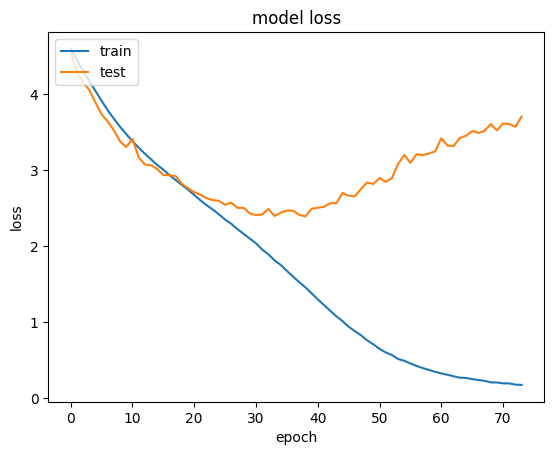

100/100 [==============================] - 1s 5ms/step - loss: 2.5750 - accuracy: 0.3637

Test score/loss: 2.574983596801758
Test accuracy: 0.3637000024318695


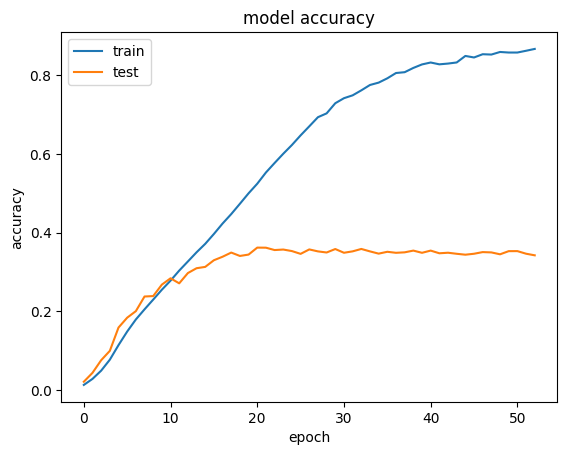

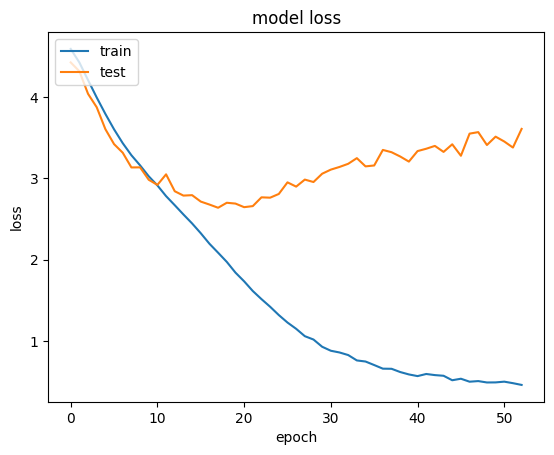

In [28]:
for i in range(0, len(learningRates)):
    lr = learningRates[i]
    model = tf.keras.saving.load_model(f"alexNet_lr_{lr}_def.keras")
    history = np.load(f"alexNet_lr_{lr}_history.npy", allow_pickle='TRUE').item()
    score = model.evaluate(input_X_test, output_Y_test, batch_size=BATCH_SIZE, verbose=VERBOSE)
    print("\nTest score/loss:", score[0])
    print('Test accuracy:', score[1])
    # summarize history for accuracy
    #plt.plot(mo)
    plt.plot(history['accuracy'])
    plt.plot(history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    # summarize history for loss
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [30]:
lr = learningRates[0]
inp = tf.keras.Input(shape=(IMG_ROWS, IMG_COLS, IMG_CHANNELS))
conv1 = tf.keras.layers.Conv2D(kernel_size=11, filters=82, padding="same", strides=(2, 2), activation="relu")(inp)
pool1 = tf.keras.layers.MaxPool2D(pool_size=(3, 3), strides=(1, 1))(conv1)
conv2 = tf.keras.layers.Conv2D(kernel_size=5 , padding="same", filters=168, activation="relu", strides=(1, 1))(pool1)
pool2 = tf.keras.layers.MaxPool2D(pool_size=(3, 3), strides=(1, 1))(conv2)
conv3 = tf.keras.layers.Conv2D(kernel_size=3, filters=212, activation="relu", padding="same", strides=(1, 1))(pool2)
conv4 = tf.keras.layers.Conv2D(kernel_size=3, filters=212, activation="relu", padding="same", strides=(1, 1))(conv3)
conv5 = tf.keras.layers.Conv2D(kernel_size=3, filters=212, activation="relu", padding="same", strides=(1, 1))(conv4)
pool3 = tf.keras.layers.MaxPool2D(pool_size=(3, 3), strides=(1, 1))(conv5)
flatten = tf.keras.layers.Flatten()(pool3)
dense1 = tf.keras.layers.Dense(units=2048, activation="relu")(flatten)
dropout1 = tf.keras.layers.Dropout(dropoutRates[1])(dense1)
dense2 = tf.keras.layers.Dense(units=2048, activation="relu")(dropout1)
dropout2 = tf.keras.layers.Dropout(dropoutRates[1])(dense2)
predictions = tf.keras.layers.Dense(units=N_CLASSES, activation="softmax")(dropout2)
model = tf.keras.Model(inputs=inp, outputs=predictions)
model.summary()
model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.SGD(learning_rate=lr, momentum=0.9), metrics=['accuracy'])
history = model.fit(np.array(input_X_train), np.array(output_Y_train), batch_size=BATCH_SIZE, epochs=N_EPOCH, validation_split=VALIDATION_SPLIT, verbose=VERBOSE, callbacks=[es])
model.save(f"alexNet_momentum.keras")
np.save(f"alexNet_momentum_history.npy", history.history)

Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_45 (Conv2D)          (None, 16, 16, 82)        29848     
                                                                 
 max_pooling2d_33 (MaxPooli  (None, 14, 14, 82)        0         
 ng2D)                                                           
                                                                 
 conv2d_46 (Conv2D)          (None, 14, 14, 168)       344568    
                                                                 
 max_pooling2d_34 (MaxPooli  (None, 12, 12, 168)       0         
 ng2D)                                                           
                                                                 
 conv2d_47 (Conv2D)          (None, 12, 12, 212)       320

In [8]:
lr = learningRates[0]
inp = tf.keras.Input(shape=(IMG_ROWS, IMG_COLS, IMG_CHANNELS))
conv1 = tf.keras.layers.Conv2D(kernel_size=11, filters=82, padding="same", strides=(2, 2), activation="relu")(inp)
pool1 = tf.keras.layers.MaxPool2D(pool_size=(3, 3), strides=(1, 1))(conv1)
conv2 = tf.keras.layers.Conv2D(kernel_size=5 , padding="same", filters=168, activation="relu", strides=(1, 1))(pool1)
pool2 = tf.keras.layers.MaxPool2D(pool_size=(3, 3), strides=(1, 1))(conv2)
conv3 = tf.keras.layers.Conv2D(kernel_size=3, filters=212, activation="relu", padding="same", strides=(1, 1))(pool2)
conv4 = tf.keras.layers.Conv2D(kernel_size=3, filters=212, activation="relu", padding="same", strides=(1, 1))(conv3)
conv5 = tf.keras.layers.Conv2D(kernel_size=3, filters=212, activation="relu", padding="same", strides=(1, 1))(conv4)
pool3 = tf.keras.layers.MaxPool2D(pool_size=(3, 3), strides=(1, 1))(conv5)
flatten = tf.keras.layers.Flatten()(pool3)
dense1 = tf.keras.layers.Dense(units=2048, activation="relu")(flatten)
dropout1 = tf.keras.layers.Dropout(dropoutRates[1])(dense1)
dense2 = tf.keras.layers.Dense(units=2048, activation="relu")(dropout1)
dropout2 = tf.keras.layers.Dropout(dropoutRates[1])(dense2)
predictions = tf.keras.layers.Dense(units=N_CLASSES, activation="softmax")(dropout2)
model = tf.keras.Model(inputs=inp, outputs=predictions)
model.summary()
model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.SGD(learning_rate=lr, momentum=0.9, nesterov=True), metrics=['accuracy'])
history = model.fit(np.array(input_X_train), np.array(output_Y_train), batch_size=BATCH_SIZE, epochs=N_EPOCH, validation_split=VALIDATION_SPLIT, verbose=VERBOSE, callbacks=[es])
model.save(f"alexNet_momentum_nesterov.keras")
np.save(f"alexNet_momentum_nesterov_history.npy", history.history)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 16, 16, 82)        29848     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 14, 14, 82)        0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 14, 14, 168)       344568    
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 12, 12, 168)       0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 12, 12, 212)       3207

2024-04-22 17:47:51.609754: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
2024-04-22 17:47:51.711435: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-04-22 17:47:51.939667: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-04-22 17:47:52.303197: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f4c1968ac40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-22 17:47:52.303229: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 SUPER, Compute Capability 8.9
I0000 00:00:1713804472.326199   82647 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


400/400 [==============================] - 9s 16ms/step - loss: 4.5116 - accuracy: 0.0194 - val_loss: 4.2946 - val_accuracy: 0.0396
Epoch 2/100
400/400 [==============================] - 6s 16ms/step - loss: 4.1655 - accuracy: 0.0556 - val_loss: 3.8676 - val_accuracy: 0.1068
Epoch 3/100
400/400 [==============================] - 6s 16ms/step - loss: 3.8243 - accuracy: 0.1084 - val_loss: 3.5634 - val_accuracy: 0.1566
Epoch 4/100
400/400 [==============================] - 6s 15ms/step - loss: 3.5715 - accuracy: 0.1513 - val_loss: 3.3964 - val_accuracy: 0.1810
Epoch 5/100
400/400 [==============================] - 6s 14ms/step - loss: 3.3677 - accuracy: 0.1876 - val_loss: 3.2066 - val_accuracy: 0.2254
Epoch 6/100
400/400 [==============================] - 6s 14ms/step - loss: 3.1930 - accuracy: 0.2172 - val_loss: 3.0528 - val_accuracy: 0.2518
Epoch 7/100
400/400 [==============================] - 6s 14ms/step - loss: 3.0290 - accuracy: 0.2527 - val_loss: 2.8982 - val_accuracy: 0.2830
Epoc

100/100 [==============================] - 1s 6ms/step - loss: 2.3058 - accuracy: 0.4240

Test score/loss: 2.3057596683502197
Test accuracy: 0.42399999499320984


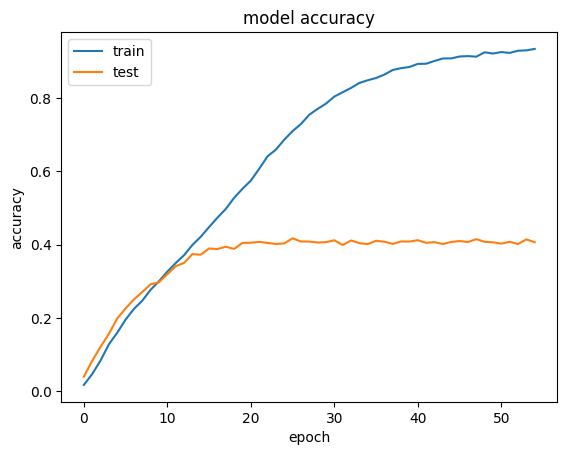

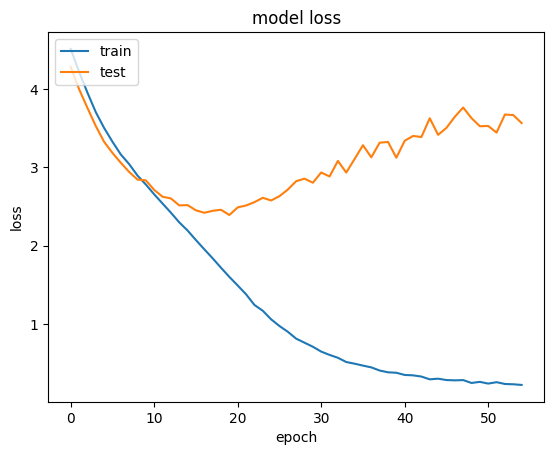

In [9]:
model = tf.keras.saving.load_model(f"alexNet_momentum.keras")
history = np.load(f"alexNet_momentum_history.npy", allow_pickle='TRUE').item()
score = model.evaluate(input_X_test, output_Y_test, batch_size=BATCH_SIZE, verbose=VERBOSE)
print("\nTest score/loss:", score[0])
print('Test accuracy:', score[1])
# summarize history for accuracy
#plt.plot(mo)
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

100/100 [==============================] - 1s 5ms/step - loss: 2.2168 - accuracy: 0.4383

Test score/loss: 2.216810464859009
Test accuracy: 0.4383000135421753


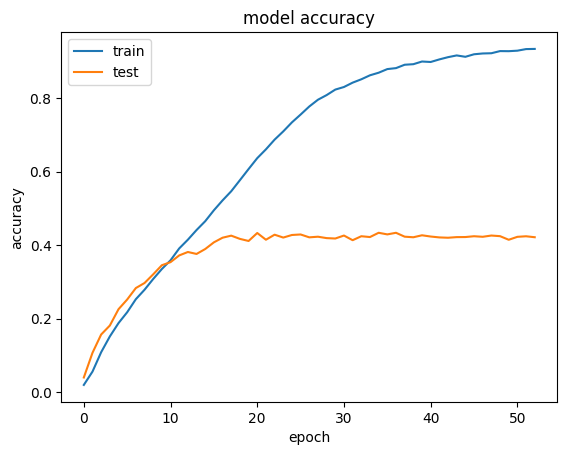

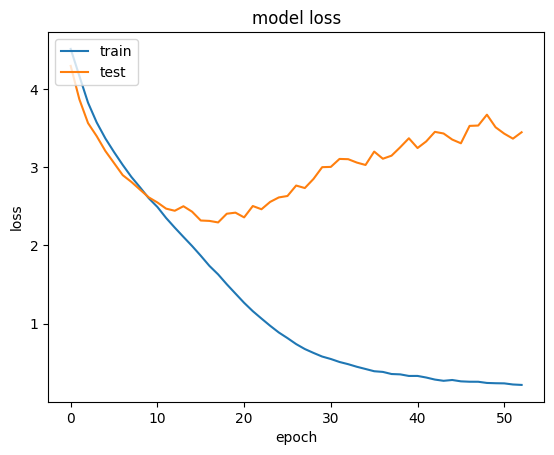

In [10]:
model = tf.keras.saving.load_model(f"alexNet_momentum_nesterov.keras")
history = np.load(f"alexNet_momentum_nesterov_history.npy", allow_pickle='TRUE').item()
score = model.evaluate(input_X_test, output_Y_test, batch_size=BATCH_SIZE, verbose=VERBOSE)
print("\nTest score/loss:", score[0])
print('Test accuracy:', score[1])
# summarize history for accuracy
#plt.plot(mo)
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [13]:
lr = learningRates[0]
inp = tf.keras.Input(shape=(IMG_ROWS, IMG_COLS, IMG_CHANNELS))
conv1 = tf.keras.layers.Conv2D(kernel_size=11, filters=82, padding="same", strides=(2, 2), activation="relu")(inp)
pool1 = tf.keras.layers.MaxPool2D(pool_size=(3, 3), strides=(1, 1))(conv1)
conv2 = tf.keras.layers.Conv2D(kernel_size=5 , padding="same", filters=168, activation="relu", strides=(1, 1))(pool1)
pool2 = tf.keras.layers.MaxPool2D(pool_size=(3, 3), strides=(1, 1))(conv2)
conv3 = tf.keras.layers.Conv2D(kernel_size=3, filters=212, activation="relu", padding="same", strides=(1, 1))(pool2)
conv4 = tf.keras.layers.Conv2D(kernel_size=3, filters=212, activation="relu", padding="same", strides=(1, 1))(conv3)
conv5 = tf.keras.layers.Conv2D(kernel_size=3, filters=212, activation="relu", padding="same", strides=(1, 1))(conv4)
pool3 = tf.keras.layers.MaxPool2D(pool_size=(3, 3), strides=(1, 1))(conv5)
flatten = tf.keras.layers.Flatten()(pool3)
dense1 = tf.keras.layers.Dense(units=2048, activation="relu")(flatten)
dropout1 = tf.keras.layers.Dropout(dropoutRates[1])(dense1)
dense2 = tf.keras.layers.Dense(units=2048, activation="relu")(dropout1)
dropout2 = tf.keras.layers.Dropout(dropoutRates[1])(dense2)
predictions = tf.keras.layers.Dense(units=N_CLASSES, activation="softmax")(dropout2)
model = tf.keras.Model(inputs=inp, outputs=predictions)
model.summary()
model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.SGD(learning_rate=lr, momentum=0.9, nesterov=True, weight_decay=0.004), metrics=['accuracy'])
history = model.fit(np.array(input_X_train), np.array(output_Y_train), batch_size=BATCH_SIZE, epochs=N_EPOCH, validation_split=VALIDATION_SPLIT, verbose=VERBOSE, callbacks=[es])
model.save(f"alexNet_weight_decay_def.keras")
np.save(f"alexNet_weight_decay_history.npy", history.history)

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_15 (Conv2D)          (None, 16, 16, 82)        29848     
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 14, 14, 82)        0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 14, 14, 168)       344568    
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 12, 12, 168)       0         
 ng2D)                                                           
                                                                 
 conv2d_17 (Conv2D)          (None, 12, 12, 212)       3207

100/100 [==============================] - 1s 5ms/step - loss: 2.2473 - accuracy: 0.4337

Test score/loss: 2.247325897216797
Test accuracy: 0.43369999527931213


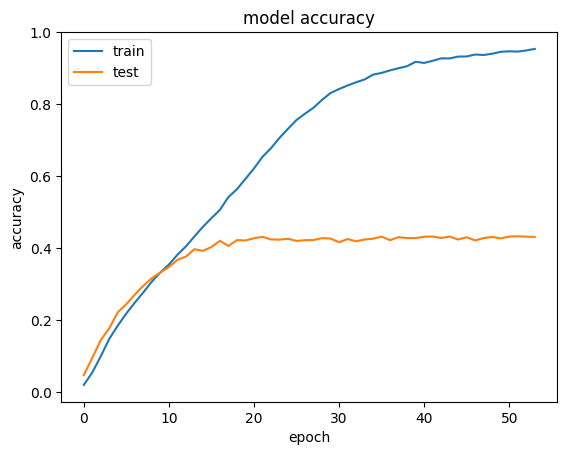

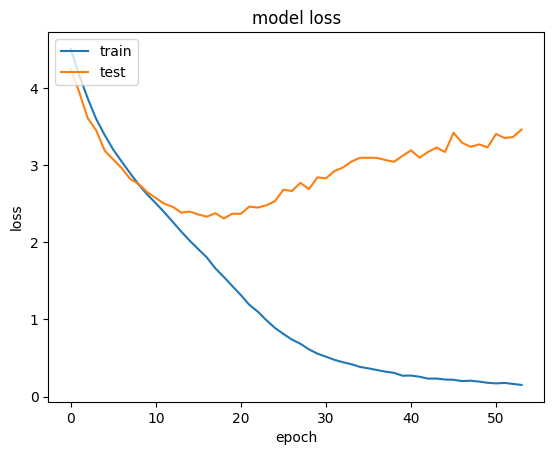

In [14]:
model = tf.keras.saving.load_model(f"alexNet_weight_decay_def.keras")
history = np.load(f"alexNet_weight_decay_history.npy", allow_pickle='TRUE').item()
score = model.evaluate(input_X_test, output_Y_test, batch_size=BATCH_SIZE, verbose=VERBOSE)
print("\nTest score/loss:", score[0])
print('Test accuracy:', score[1])
# summarize history for accuracy
#plt.plot(mo)
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [8]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
   width_shift_range=0.15,
   height_shift_range=0.15,
   zoom_range=0.15,
   horizontal_flip=True,
   fill_mode='nearest')

#fit the dataset
lr = learningRates[0]
inp = tf.keras.Input(shape=(IMG_ROWS, IMG_COLS, IMG_CHANNELS))
conv1 = tf.keras.layers.Conv2D(kernel_size=11, filters=82, padding="same", strides=(2, 2), activation="relu")(inp)
pool1 = tf.keras.layers.MaxPool2D(pool_size=(3, 3), strides=(1, 1))(conv1)
conv2 = tf.keras.layers.Conv2D(kernel_size=5 , padding="same", filters=168, activation="relu", strides=(1, 1))(pool1)
pool2 = tf.keras.layers.MaxPool2D(pool_size=(3, 3), strides=(1, 1))(conv2)
conv3 = tf.keras.layers.Conv2D(kernel_size=3, filters=212, activation="relu", padding="same", strides=(1, 1))(pool2)
conv4 = tf.keras.layers.Conv2D(kernel_size=3, filters=212, activation="relu", padding="same", strides=(1, 1))(conv3)
conv5 = tf.keras.layers.Conv2D(kernel_size=3, filters=212, activation="relu", padding="same", strides=(1, 1))(conv4)
pool3 = tf.keras.layers.MaxPool2D(pool_size=(3, 3), strides=(1, 1))(conv5)
flatten = tf.keras.layers.Flatten()(pool3)
dense1 = tf.keras.layers.Dense(units=2048, activation="relu")(flatten)
dropout1 = tf.keras.layers.Dropout(dropoutRates[1])(dense1)
dense2 = tf.keras.layers.Dense(units=2048, activation="relu")(dropout1)
dropout2 = tf.keras.layers.Dropout(dropoutRates[1])(dense2)
predictions = tf.keras.layers.Dense(units=N_CLASSES, activation="softmax")(dropout2)
model = tf.keras.Model(inputs=inp, outputs=predictions)
model.summary()
model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.SGD(learning_rate=lr, momentum=0.9, nesterov=True), metrics=['accuracy'])
validationData = (input_X_train[round(len(input_X_train) * (1 - VALIDATION_SPLIT)):len(input_X_train)], output_Y_train[round(len(output_Y_train) * (1 - VALIDATION_SPLIT)):len(output_Y_train)])
datagen.fit(input_X_train[0:round(len(input_X_train) * (1 - VALIDATION_SPLIT))], rounds=2)
history = model.fit(datagen.flow(input_X_train[0:round(len(input_X_train) * (1 - VALIDATION_SPLIT))], 
                                 output_Y_train[0:round(len(output_Y_train) * (1 - VALIDATION_SPLIT))], 
                                 batch_size=BATCH_SIZE), steps_per_epoch=round(len(input_X_train) * (1 - VALIDATION_SPLIT)) // BATCH_SIZE, validation_data=validationData, epochs=N_EPOCH, verbose=1, callbacks=[es])
model.save(f"alexNet_augmented_.keras")
np.save(f"alexNet_augmented_history.npy", history.history)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 16, 16, 82)        29848     
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 82)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 168)       344568    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 12, 12, 168)       0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 212)       3207

2024-04-22 18:42:31.993488: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
2024-04-22 18:42:32.073690: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-04-22 18:42:32.258336: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-04-22 18:42:32.596484: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f71ad910050 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-22 18:42:32.596512: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 SUPER, Compute Capability 8.9
I0000 00:00:1713807752.619074  110185 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


400/400 [==============================] - 12s 25ms/step - loss: 4.5339 - accuracy: 0.0168 - val_loss: 4.3302 - val_accuracy: 0.0369
Epoch 2/100
400/400 [==============================] - 10s 25ms/step - loss: 4.2480 - accuracy: 0.0420 - val_loss: 4.0360 - val_accuracy: 0.0722
Epoch 3/100
400/400 [==============================] - 10s 25ms/step - loss: 4.0147 - accuracy: 0.0716 - val_loss: 3.7982 - val_accuracy: 0.1112
Epoch 4/100
400/400 [==============================] - 10s 24ms/step - loss: 3.8134 - accuracy: 0.1062 - val_loss: 3.6610 - val_accuracy: 0.1377
Epoch 5/100
400/400 [==============================] - 10s 24ms/step - loss: 3.6383 - accuracy: 0.1355 - val_loss: 3.4489 - val_accuracy: 0.1706
Epoch 6/100
400/400 [==============================] - 10s 25ms/step - loss: 3.4971 - accuracy: 0.1594 - val_loss: 3.2416 - val_accuracy: 0.2075
Epoch 7/100
400/400 [==============================] - 10s 24ms/step - loss: 3.3660 - accuracy: 0.1857 - val_loss: 3.0803 - val_accuracy: 0.24

100/100 [==============================] - 1s 5ms/step - loss: 1.8483 - accuracy: 0.5384

Test score/loss: 1.8483480215072632
Test accuracy: 0.5383999943733215
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


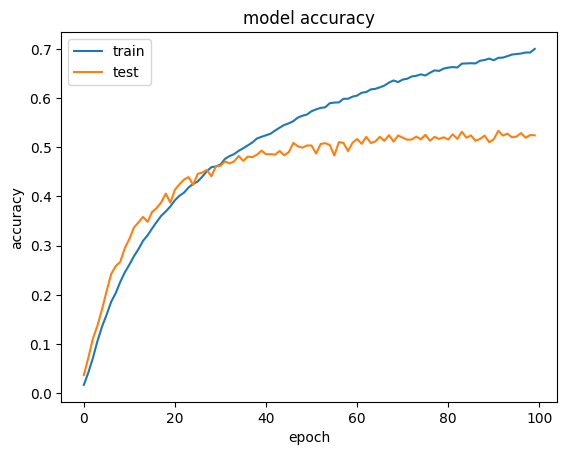

91


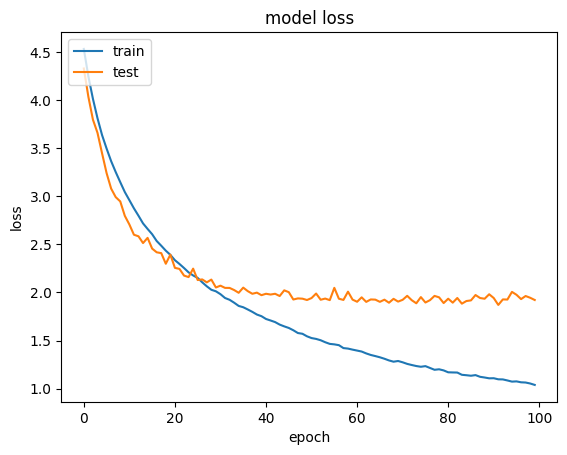

In [14]:
model = tf.keras.saving.load_model("alexNet_augmented_.keras")
history = np.load("alexNet_augmented_history.npy", allow_pickle='TRUE').item()
score = model.evaluate(input_X_test, output_Y_test, batch_size=BATCH_SIZE, verbose=VERBOSE)
print("\nTest score/loss:", score[0])
print('Test accuracy:', score[1])

# list all data in history
print(history.keys())

# summarize history for accuracy
#plt.plot(mo)
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
print(np.argmin(history['val_loss']))
# summarize history for loss
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

100/100 [==============================] - 1s 5ms/step - loss: 4.9596 - accuracy: 0.3170

Test score/loss: 4.959563732147217
Test accuracy: 0.31700000166893005
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


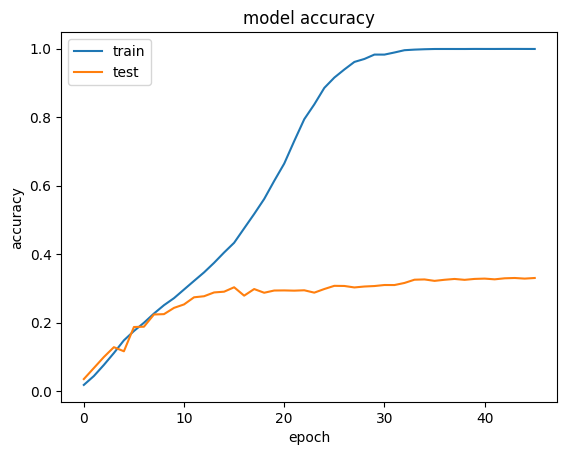

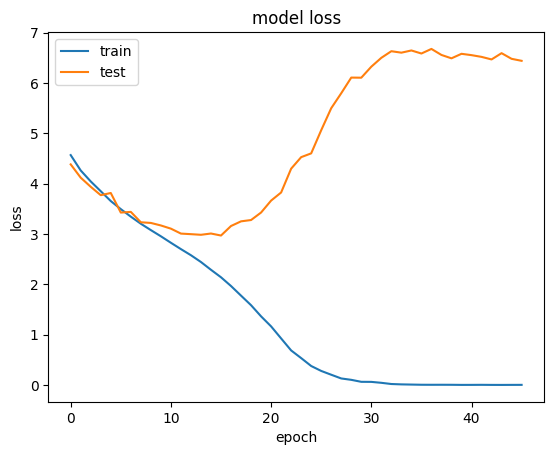

In [10]:
model = tf.keras.saving.load_model("alexNet_def.keras")
history = np.load("alexNet_def_history.npy", allow_pickle='TRUE').item()
score = model.evaluate(input_X_test, output_Y_test, batch_size=BATCH_SIZE, verbose=VERBOSE)
print("\nTest score/loss:", score[0])
print('Test accuracy:', score[1])

# list all data in history
print(history.keys())

# summarize history for accuracy
#plt.plot(mo)
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [22]:
resNet = apps.ResNet50V2(classes=N_CLASSES, weights=None, include_top=False, pooling="max", input_shape=input_X_train[0].shape)
avgPool = tf.keras.layers.GlobalAveragePooling2D()(resNet.layers[-2].output)
flatten = Flatten()(avgPool)
predictions = Dense(N_CLASSES, activation="softmax", name="predictions")(flatten)
print(len(resNet.layers))
model = tf.keras.Model(inputs=resNet.inputs, outputs=predictions)
model.summary()
model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.SGD(), metrics=['accuracy'])

191
Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_8 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 38, 38, 3)            0         ['input_8[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 16, 16, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, 18, 18, 64)           0         ['conv1_conv[0][0]']          
                                                                                        

In [23]:
history = model.fit(np.array(input_X_train), np.array(output_Y_train), batch_size=BATCH_SIZE, epochs=N_EPOCH, validation_split=VALIDATION_SPLIT,  verbose=VERBOSE, callbacks=[es])
model.save("resNet_def.keras")
np.save("resNet_def_history.npy", history.history)

Epoch 1/100
400/400 [==============================] - 19s 31ms/step - loss: 4.3015 - accuracy: 0.0595 - val_loss: 4.0225 - val_accuracy: 0.0884
Epoch 2/100
400/400 [==============================] - 12s 30ms/step - loss: 3.7962 - accuracy: 0.1230 - val_loss: 3.7662 - val_accuracy: 0.1313
Epoch 3/100
400/400 [==============================] - 12s 30ms/step - loss: 3.5233 - accuracy: 0.1666 - val_loss: 3.6267 - val_accuracy: 0.1534
Epoch 4/100
400/400 [==============================] - 12s 29ms/step - loss: 3.3042 - accuracy: 0.2040 - val_loss: 3.5087 - val_accuracy: 0.1692
Epoch 5/100
400/400 [==============================] - 11s 26ms/step - loss: 3.1046 - accuracy: 0.2418 - val_loss: 3.3858 - val_accuracy: 0.1966
Epoch 6/100
400/400 [==============================] - 13s 32ms/step - loss: 2.9237 - accuracy: 0.2784 - val_loss: 3.3198 - val_accuracy: 0.2085
Epoch 7/100
400/400 [==============================] - 12s 31ms/step - loss: 2.7424 - accuracy: 0.3133 - val_loss: 3.2942 - val_ac

100/100 [==============================] - 1s 7ms/step - loss: 3.2048 - accuracy: 0.2493

Test score/loss: 3.2048325538635254
Test accuracy: 0.2493000030517578
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


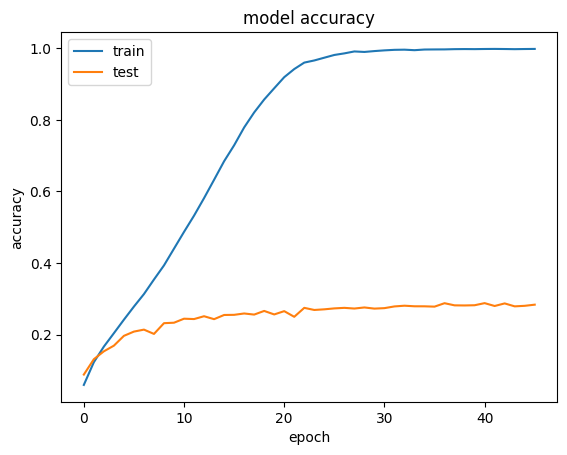

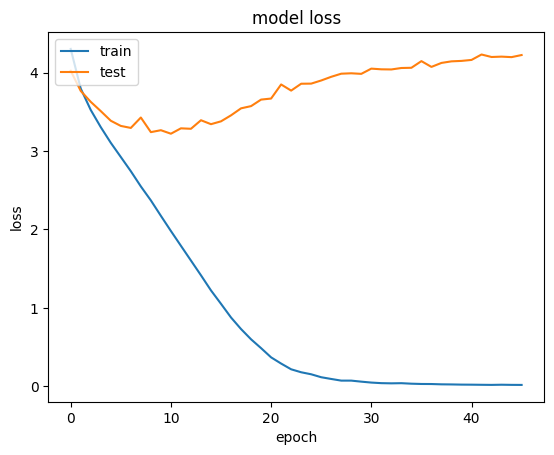

In [24]:
model = tf.keras.saving.load_model("resNet_def.keras")
history = np.load("resNet_def_history.npy", allow_pickle='TRUE').item()
score = model.evaluate(input_X_test, output_Y_test, batch_size=BATCH_SIZE, verbose=VERBOSE)
print("\nTest score/loss:", score[0])
print('Test accuracy:', score[1])

# list all data in history
print(history.keys())

# summarize history for accuracy
#plt.plot(mo)
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()